In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# import numpy as np

In [10]:
product_info_file_path = '../data/product_info.csv'
data = pd.read_csv(product_info_file_path)
data_info = data.info()
data_head = data.head()
data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

(None,
   product_id               product_name  brand_id brand_name  loves_count  \
 0    P473671    Fragrance Discovery Set      6342      19-69         6320   
 1    P473668    La Habana Eau de Parfum      6342      19-69         3827   
 2    P473662  Rainbow Bar Eau de Parfum      6342      19-69         3253   
 3    P473660       Kasbah Eau de Parfum      6342      19-69         3018   
 4    P473658  Purple Haze Eau de Parfum      6342      19-69         2691   
 
    rating  reviews            size                      variation_type  \
 0  3.6364     11.0             NaN                                 NaN   
 1  4.1538     13.0  3.4 oz/ 100 mL  Size + Concentration + Formulation   
 2  4.2500     16.0  3.4 oz/ 100 mL  Size + Concentration + Formulation   
 3  4.4762     21.0  3.4 oz/ 100 mL  Size + Concentration + Formulation   
 4  3.2308     13.0  3.4 oz/ 100 mL  Size + Concentration + Formulation   
 
   variation_value  ... online_only out_of_stock  sephora_exclusive  \


In [11]:
product_info_df = data.copy()
product_info_df = product_info_df[product_info_df['primary_category'].isin( ['Bath & Body', 'Hair', 'Makeup', 'Skincare'])]

# product_info_df.drop(['size', 'variation_type', 'variation_value','variation_desc', 'value_price_usd', 'sale_price_usd', 'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'child_count','child_max_price', 'child_min_price'], axis=1, inplace=True)
# product_info_df.rename(columns={'rating': 'overall_rating'}, inplace=True)

# 1. Handle Missing Values
# For numerical columns (e.g., 'rating', 'reviews'), impute with median
numerical_cols = product_info_df.select_dtypes(include=['float64', 'int64']).columns
print(numerical_cols)
num_imputer = SimpleImputer(strategy='median')
product_info_df[numerical_cols] = num_imputer.fit_transform(product_info_df[numerical_cols])

Index(['brand_id', 'loves_count', 'rating', 'reviews', 'price_usd',
       'value_price_usd', 'sale_price_usd', 'limited_edition', 'new',
       'online_only', 'out_of_stock', 'sephora_exclusive', 'child_count',
       'child_max_price', 'child_min_price'],
      dtype='object')


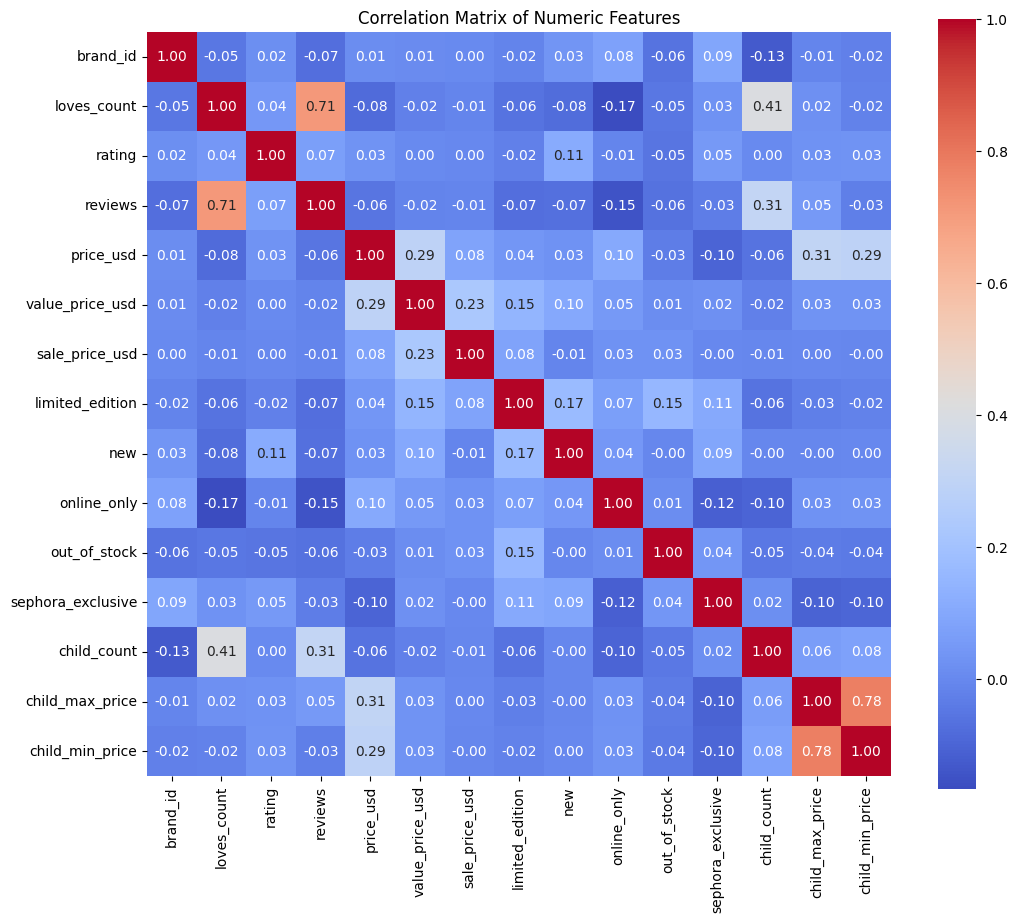

,brand_id,loves_count,rating,reviews,price_usd,value_price_usd,sale_price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,child_count,child_max_price,child_min_price
brand_id,1.000000,-0.050937,0.019700,-0.073559,0.012743,0.008184,0.004978,-0.015354,0.034984,0.076877,-0.060120,0.089324,-0.127798,-0.007968,-0.023953
loves_count,-0.050937,1.000000,0.044424,0.711880,-0.083917,-0.021768,-0.010622,-0.058673,-0.076686,-0.166801,-0.051746,0.025269,0.406116,0.020205,-0.018371
rating,0.019700,0.044424,1.000000,0.068997,0.033483,0.004489,0.000053,-0.021773,0.109312,-0.007982,-0.053299,0.050093,0.002915,0.025839,0.031865
reviews,-0.073559,0.711880,0.068997,1.000000,-0.055959,-0.015575,-0.008718,-0.073452,-0.067225,-0.145127,-0.062681,-0.033872,0.307857,0.049096,-0.027679
price_usd,0.012743,-0.083917,0.033483,-0.055959,1.000000,0.289343,0.083731,0.042816,0.028470,0.104957,-0.032845,-0.101553,-0.060961,0.306639,0.291593
value_price_usd,0.008184,-0.021768,0.004489,-0.015575,0.289343,1.000000,0.228363,0.147409,0.100595,0.050960,0.013536,0.023963,-0.021411,0.032450,0.030148
sale_price_usd,0.004978,-0.010622,0.000053,-0.008718,0.083731,0.228363,1.000000,0.079500,-0.010473,0.025834,0.025637,-0.000277,-0.006349,0.000926,-0.003823
limited_edition,-0.015354,-0.058673,-0.021773,-0.073452,0.042816,0.147409,0.079500,1.000000,0.166067,0.065664,0.153859,0.106601,-0.058623,-0.025637,-0.018111
new,0.034984,-0.076686,0.109312,-0.067225,0.028470,0.100595,-0.010473,0.166067,1.000000,0.044388,-0.003047,0.091928,-0.002804,-0.003204,0.000986
online_only,0.076877,-0.166801,-0.007982,-0.145127,0.104957,0.050960,0.025834,0.065664,0.044388,1.000000,0.011504,-0.115131,-0.100929,0.026202,0.032982


In [12]:
correlation_matrix = product_info_df[numerical_cols].corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

correlation_matrix

In [13]:
# For categorical columns (e.g., 'size', 'variation_type'), impute with most frequent
categorical_cols = ['primary_category', 'secondary_category', 'tertiary_category', 'size', 'variation_type', 'variation_value','variation_desc']
cat_imputer = SimpleImputer(strategy='most_frequent')
product_info_df[categorical_cols] = cat_imputer.fit_transform(product_info_df[categorical_cols])

In [14]:
# Encoding binary categorical columns
binary_cols = ['limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive']
product_info_df[binary_cols] = product_info_df[binary_cols].astype(int)

In [15]:
# Encoding specific categorical columns with Label Encoding
label_encoder_cols = ['brand_name', 'primary_category', 'secondary_category', 'tertiary_category']
label_encoders = {col: LabelEncoder() for col in label_encoder_cols}
for col in label_encoder_cols:
    product_info_df[col] = label_encoders[col].fit_transform(product_info_df[col].astype(str))

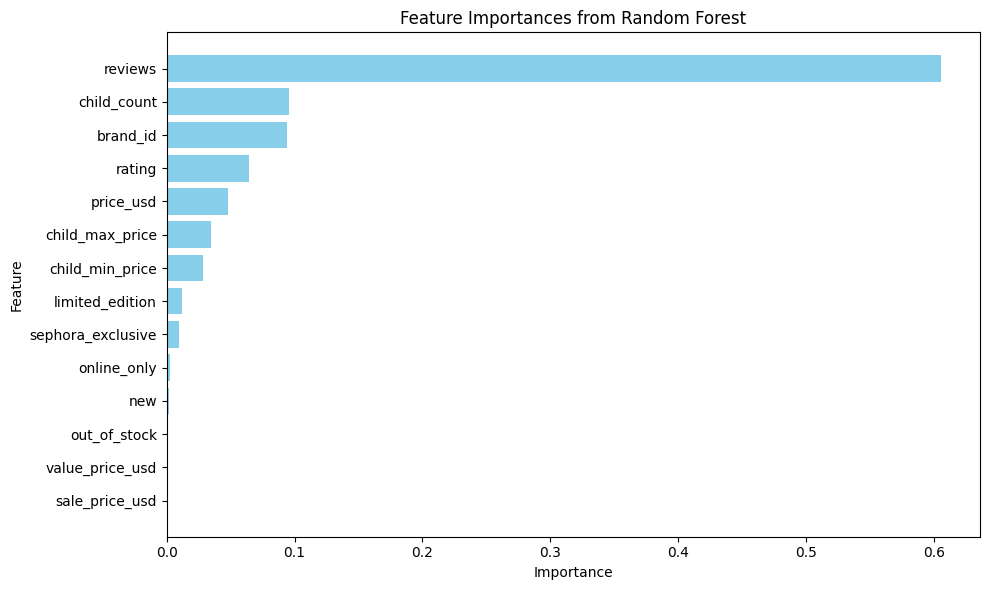

In [16]:
# Selecting numeric features (excluding the target 'rating')
target_variable = 'loves_count'
features = numerical_cols.drop(target_variable)
X = product_info_df[features]
y = product_info_df[target_variable]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

# Extract feature importances
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the feature importance table using matplotlib for visualization
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()